In [1]:
#team member names
#Joseph Gill, Andy Ho, Nathalie Murphy, Natalia Rivera, Yashesha Kothari, Sibhi Sakthivel 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def randSteps(stepSize_mu: np.array = np.ones((2,1)),
              stepSize_std: np.array = np.ones((2,1)),
              N_steps: int = 4):


  """
  This function generates a random step <x,y> vector, where the user
  can tightly control the step size but has no influence on the direction

  Inputs:
      #stepSize_mu = the mean distance to travel
      #stepSize_std = the standard deviation from the mean distance to travel
      #N_steps = how many random step vectors to genrate: < x[0:N], y[0:N] >

  Outputs:
      x,y np.arrays((N_steps,1))
  """
  #Initialize x,y columns with one more row than steps

  x = np.zeros((N_steps+1,1))
  y = np.zeros((N_steps+1,1))

  x_tumbles = np.random.normal(stepSize_mu[0],stepSize_std[0],N_steps)
  y_tumbles = np.random.normal(stepSize_mu[1],stepSize_std[1],N_steps)

  x_tumbles *= np.random.choice([-1,1],size = np.shape(x_tumbles))
  y_tumbles *= np.random.choice([-1,1],size = np.shape(y_tumbles))


  x[1:,0] = np.cumsum(x_tumbles)
  y[1:,0] = np.cumsum(y_tumbles)



  return x,y




#define E.coli class
class Ecoli_Walk():

  """
    This class sets the following:
        1) 3 Food Location Function Choices:
                - 'Polynom_2'
                - 'Polynom_4'
                - 'NormalDist'

        2) Food Location Variable Choices are available via **kwargs

        3) Analytical or numerical gradient calculation choice
                - Analytical gradients are provided for the 3 provided
                food locations equations

                - Analytical gradients can be used by setting
                "analytical_Grad" = True

                - Numerical gradients have a finite delta limit determined by
                the input "gradEst_MinDelta"


        4) Optimizer choices
                - Momentum  + decay rate specified in **kwargs
                - Adagrad
                - RMSProp  + decay rate specified in **kwargs
                - ADAM-like momentum  + decay rate specified in **kwargs

        5) Initlial E.Coli positions

        6) Random step criteria:
            - Number os random steps
            - Average Tumble to Run Length Ratios
            - Standard Distribution of tumble lengths

        7) Total iterations (tumbles + run step)

        8) Plot Levels for the Food Location Function

    """

  def __init__(self,
              #Function Params:
              foodFunctionType: str = 'Polynom_2',
              foodLoc_X: float = 1.05,
              foodLoc_Y: float = 0,

              #Gradient Params:
              gradEst_MinDelta: float = 1e-4,
              analytical_Grad: bool = False,


              #Simulation Params
              iterationCount: int = 30,
              X_init: float = 8,
              Y_init: float = -8,
              tumbles: int = 4,
              run2tumble_lengthRatio = 10,
              avg2std_tumbleRatio: float = 100,
              N: int = 10,

              #Optimizer Params
              optimizeType: int = 0,

              #Plotting Params
              plotLevels: int = 20,
              **kwargs
              ):
    #Simulation Params
    self.iterationCount = iterationCount
    self.X_init = X_init
    self.Y_init = Y_init
    self.tumbles = tumbles
    self.run2tumble_lengthRatio  = run2tumble_lengthRatio
    self.avg2std_tumbleRatio = avg2std_tumbleRatio

    #Gradient Param:
    self.gradEst_MinDelta = gradEst_MinDelta

    #Set Gradient Function as estimation; will update if anayltical is requested
    self.Grad_func = self.Grad_estimation
    self.analytical_Grad = analytical_Grad

    #__________________________________________________________________________#
    ####Food Function Params:
    self.foodFunctionType = foodFunctionType

    foodFuncVars = {'Polynom_2__A': -3e-8,
                    'Polynom_2__a': 1,
                    'Polynom_2__B': -1e-8,
                    'Polynom_2__b': 2,
                    'Polynom_2__C': 3,

                    'Polynom_4__a1': -1/2,
                    'Polynom_4__b1': -1/4,
                    'Polynom_4__c1': 3/2,
                    'Polynom_4__d1': 0,
                    'Polynom_4__e1': 5,
                    'Polynom_4__a2': -1/2,
                    'Polynom_4__b2': -1/4,
                    'Polynom_4__c2': 3/2,
                    'Polynom_4__d2': 0,
                    'Polynom_4__e2': 5,

                    'NormalDist_var_X': 5,
                    'NormalDist_mu_X': 0,
                    'NormalDist_var_Y': 5,
                    'NormalDist_mu_Y': 0,
        }

    for key in kwargs:
      #Polynom_2 vars
      if key == 'Polynom_2__A':
          foodFuncVars['Polynom_2__A'] = kwargs[key]
      elif key == 'Polynom_2__a':
          foodFuncVars['Polynom_2__a'] = kwargs[key]
      elif key == 'Polynom_2__B':
          foodFuncVars['Polynom_2__B'] = kwargs[key]
      elif key == 'Polynom_2__b':
          foodFuncVars['Polynom_2__b'] = kwargs[key]
      elif key == 'Polynom_2__C':
          foodFuncVars['Polynom_2__C'] = kwargs[key]

      #Polynom 4 vars:
      elif key == 'Polynom_4__a1':
          foodFuncVars['Polynom_4__a1'] = kwargs[key]
      elif key == 'Polynom_4__b1':
          foodFuncVars['Polynom_4__b1'] = kwargs[key]
      elif key == 'Polynom_4__c1':
          foodFuncVars['Polynom_4__c1'] = kwargs[key]
      elif key == 'Polynom_4__d1':
          foodFuncVars['Polynom_4__d1'] = kwargs[key]
      elif key == 'Polynom_4__e1':
          foodFuncVars['Polynom_4__e1'] = kwargs[key]
      elif key == 'Polynom_4__a2':
          foodFuncVars['Polynom_4__a2'] = kwargs[key]
      elif key == 'Polynom_4__b2':
          foodFuncVars['Polynom_4__b2'] = kwargs[key]
      elif key == 'Polynom_4__c2':
          foodFuncVars['Polynom_4__c2'] = kwargs[key]
      elif key == 'Polynom_4__d2':
          foodFuncVars['Polynom_4__d2'] = kwargs[key]
      elif key == 'Polynom_4__e2':
          foodFuncVars['Polynom_4__e2'] = kwargs[key]

      #NormalDist 4 vars:
      elif key == 'NormalDist_var_X':
          foodFuncVars['NormalDist_var_X'] = kwargs[key]
      elif key == 'NormalDist_mu_X':
          foodFuncVars['NormalDist_mu_X'] = kwargs[key]
      elif key == 'NormalDist_var_Y':
          foodFuncVars['NormalDist_var_Y'] = kwargs[key]
      elif key == 'NormalDist_mu_Y':
          foodFuncVars['NormalDist_mu_Y'] = kwargs[key]

    if foodFunctionType == 'Polynom_2':
      self.foodLocFunc = self.FoodLoc_Polynom_2

      if analytical_Grad == True:
          self.Grad_func = self.analytical_Grad_Polynom_2

      self.A = foodFuncVars['Polynom_2__A']
      self.a = foodFuncVars['Polynom_2__a']
      self.B = foodFuncVars['Polynom_2__B']
      self.b = foodFuncVars['Polynom_2__b']
      self.C = foodFuncVars['Polynom_2__C']

      self.foodLoc_X = self.a
      self.foodLoc_Y = self.b

    elif foodFunctionType == 'NormalDist':
      self.foodLocFunc = self.FoodLoc_NormalDist

      if analytical_Grad == True:
          self.Grad_func = self.analytical_Grad_NormalDist

      self.ND_Var_X = foodFuncVars['NormalDist_var_X']
      self.ND_Mu_X = foodFuncVars['NormalDist_mu_X']
      self.ND_Var_Y = foodFuncVars['NormalDist_var_Y']
      self.ND_Mu_Y = foodFuncVars['NormalDist_mu_Y']

      self.foodLoc_X = 0
      self.foodLoc_Y = 0

    else:
      self.foodLocFunc = self.FoodLoc_Polynom_4

      if analytical_Grad == True:
          self.Grad_func = self.analytical_Grad_Polynom_4

      self.a1 = foodFuncVars['Polynom_4__a1']
      self.b1 = foodFuncVars['Polynom_4__b1']
      self.c1 = foodFuncVars['Polynom_4__c1']
      self.d1 = foodFuncVars['Polynom_4__d1']
      self.e1 = foodFuncVars['Polynom_4__e1']
      self.a2 = foodFuncVars['Polynom_4__a2']
      self.b2 = foodFuncVars['Polynom_4__b2']
      self.c2 = foodFuncVars['Polynom_4__c2']
      self.d2 = foodFuncVars['Polynom_4__d2']
      self.e2 = foodFuncVars['Polynom_4__e2']

      self.foodLoc_X = foodLoc_X
      self.foodLoc_Y = foodLoc_Y

    ####Optimizer Params:

    self.optimizeType = optimizeType

    optimizerConfig= {
        'learningRate': 0.01,
        'momentumRate': 0.9,
        'ADAM_momentumRate': 0.9,
        'RmsPropRate': 0.9999}

    for key in kwargs:
        if key == 'learningRate':
            optimizerConfig['learningRate'] = kwargs[key]
        elif key == 'momentumRate':
            optimizerConfig['momentumRate'] = kwargs[key]
        elif key == 'ADAM_momentumRate':
            optimizerConfig['ADAM_momentumRate'] = kwargs[key]
        elif key == 'RmsPropRate':
            optimizerConfig['RmsPropRate'] = kwargs[key]

    if optimizeType == 1:
        self.learning_R = optimizerConfig['learningRate']
        self.momentum_R = optimizerConfig['momentumRate']
        self.adaptive_R = 1

    elif optimizeType == 2:
        self.learning_R = optimizerConfig['learningRate']
        self.momentum_R = 1
        self.adaptive_R = 1

    elif optimizeType == 3:
        self.learning_R = optimizerConfig['learningRate']
        self.momentum_R = optimizerConfig['momentumRate']
        self.adaptive_R = 1

    elif optimizeType == 4:
        self.learning_R = optimizerConfig['learningRate']
        self.momentum_R = optimizerConfig['momentumRate']
        self.adaptive_R = optimizerConfig['RmsPropRate']

    elif optimizeType == 5:
        self.learning_R = optimizerConfig['learningRate']
        self.momentum_R = optimizerConfig['ADAM_momentumRate']
        self.adaptive_R = optimizerConfig['RmsPropRate']
    else:
        self.learning_R = 1
        self.momentum_R = 1
        self.adaptive_R = 1

    #__________________________________________________________________________#


    self.plotLevels = plotLevels
    self.N = N
    self.all_Ecoli_x = np.zeros((N, tumbles + 1, iterationCount))
    self.all_Ecoli_y = np.zeros((N, tumbles + 1, iterationCount))


  def analytical_Grad_NormalDist(self,X,Y):
    """
    Parameters
    ----------
    X : Previous Iteration X Column
    Y : Previous Iteration Y Column
        Analytical solution to the
        partial derivative with respect to x and y of the normal distribution

    Returns
    -------
    dZ_dX : Float type
        partial derivative of Z with respect to X
    dZ_dY : Float type
        partial derivative of Z with respect to Y

    """


    ND_Var_X = self.ND_Var_X
    ND_Mu_X = self.ND_Mu_X
    ND_Var_Y = self.ND_Var_Y
    ND_Mu_Y = self.ND_Mu_Y

    x = X[-1]
    y = Y[-1]

    P1_X = np.sqrt(2*np.pi*ND_Var_X)
    P2_X = (x - ND_Mu_X)**2 / 2*ND_Var_X

    P1_Y = np.sqrt(2*np.pi*ND_Var_Y)
    P2_Y = (y- ND_Mu_Y)**2 / 2*ND_Var_Y



    Zx = np.exp(-1*P2_X)/P1_X
    Zy = np.exp(-1*P2_Y)/P1_Y

    dZ_dX = -1*(x - ND_Mu_X ) * Zx / ND_Var_X
    dZ_dY = -1*(y - ND_Mu_Y ) * Zy / ND_Var_Y


    return dZ_dX, dZ_dY


  def FoodLoc_NormalDist(self, x: np.array = np.zeros((1,1)), y: np.array = np.zeros((1,1))):
    """
    Food source profile:
        General equation for a 3D Normal Distribution

    ND_Var_X = x variance determined in __init__ function
    ND_Mu_X = x mean determined in __init__ function
    ND_Var_Y = y variance determined in __init__ function
    ND_Mu_Y = y mean determined in __init__ function

    Parameters
    ----------
    x : np.array, optional
        Ecoli x-postion
    y : np.array, optional
        Ecoli y-postion

    Returns
    -------
    Z : Float
        Solution for for a 3D Normal Distribution

    """
    ND_Var_X = self.ND_Var_X
    ND_Mu_X = self.ND_Mu_X
    ND_Var_Y = self.ND_Var_Y
    ND_Mu_Y = self.ND_Mu_Y

    P1_X = np.sqrt(2*np.pi*ND_Var_X)
    P2_X = (x - ND_Mu_X)**2 / 2*ND_Var_X

    P1_Y = np.sqrt(2*np.pi*ND_Var_Y)
    P2_Y = (y- ND_Mu_Y)**2 / 2*ND_Var_Y

    Z = np.exp(-1*P2_X)/P1_X  + np.exp(-1*P2_Y)/P1_Y

    return Z


  def FoodLoc_Polynom_2(self, x: np.array = np.zeros((1,1)), y: np.array = np.zeros((1,1))):

    """
    Food source profile:
        General equation for a 2D parabala

    Inputs:
        A,B = scalars for x,y directions
            Values closer to 0 make the slope more gradual
            Negative values are recquiered to find an absolute max

        a,b = scalars to manipulate the location of the abs max (if A and B < 0)

        C = scale to manipuate the height of each point in the G direction

    Ouptput:
        G: np.array((1,1))
    """



    A = self.A
    a = self.a
    B = self.B
    b = self.b
    C = self.C


    Z = A*(x-a)**2  + B*(y-b)**2  + C

    return Z


  def FoodLoc_Polynom_4(self, x: np.array = np.zeros((1,1)), y: np.array = np.zeros((1,1))):

    """
    Food source profile:
        General equation for a 2D parabala

    Inputs:
        A,B = scalars for x,y directions
            Values closer to 0 make the slope more gradual
            Negative values are recquiered to find an absolute max

        a,b = scalars to manipulate the location of the abs max (if A and B < 0)

        C = scale to manipuate the height of each point in the G direction

    Ouptput:
        G: np.array((1,1))
    """



    a1 = self.a1
    b1 = self.b1
    c1 = self.c1
    d1 = self.d1
    e1 = self.e1
    a2 = self.a2
    b2 = self.b2
    c2 = self.c2
    d2 = self.d2
    e2 = self.e2


    Z = a1*x**4 + b1*x**3 + c1*x**2 + d1*x + e1  + \
        a2*y**4 + b2*y**3 + c2*y**2 + d2*x + e2

    return Z


  def analytical_Grad_Polynom_4(self,X,Y):
    a1 = self.a1
    b1 = self.b1
    c1 = self.c1
    d1 = self.d1

    a2 = self.a2
    b2 = self.b2
    c2 = self.c2
    d2 = self.d2


    x = X[-1]
    y = Y[-1]

    dZ_dX = 4*a1*x**3 + 3*b1*x**2 + 2*c1*x + d1  #Partial derivative with respect to X

    dZ_dY = 4*a2*y**3 + 3*b2*y**2 + 2*c2*y + d2 #Partial derivative with respect to Y

    return dZ_dX, dZ_dY


  def analytical_Grad_Polynom_2(self,X,Y):
    A = self.A
    a = self.a
    B = self.B
    b = self.b



    dZ_dX = 2*A*(X[-1] - a) #Partial derivative with respect to X

    dZ_dY = 2*B*(Y[-1] - b) #Partial derivative with respect to Y

    return dZ_dX, dZ_dY


  def Grad_estimation(self,X,Y):

    """
    Here we go

    """

    #Bring in function (determined in __init__)
    foodLocFunc = self.foodLocFunc


    dZ = foodLocFunc(x = X[-1], y = Y[-1]) - foodLocFunc(x = X[0], y= Y[0])

    dX = (X[-1] - X[0])
    dY = (Y[-1] - Y[0])

    #Prevent delta from becoming too small, but maintain direction:
    if dZ > 0:
        dZ += self.gradEst_MinDelta
    else:
        dZ -= self.gradEst_MinDelta

    if dX > 0:
        dX += self.gradEst_MinDelta
    else:
        dX -= self.gradEst_MinDelta

    if dY > 0:
        dY += self.gradEst_MinDelta
    else:
        dY -= self.gradEst_MinDelta

    dZ_dX = dZ / dX

    dZ_dY = dZ / dY

    return dZ_dX, dZ_dY


  def update_RandomStepLength(self, X_RunLength, Y_RunLength):
    ####Initial Run and Tumble lengths
    X = np.abs(X_RunLength)
    Y = np.abs(Y_RunLength)
    runStep = np.array(([X],[Y]))

    #set the tumble step length for (x,y)
    tumbleStep_avg = runStep / self.run2tumble_lengthRatio

    #set the tumble step variance for (x,y)
    tumbleStep_std = tumbleStep_avg  /self.avg2std_tumbleRatio

    return tumbleStep_avg, tumbleStep_std


  def EcoliWalk_Simulation(self):
    """
    Ecoli random walk simulation with food source function F1



    """


    #__________________________________________________________________________#
    ###Setting variables###
    iterationCount = self.iterationCount #Numebr of iterations

    tumblesPlusRun = self.tumbles + 1 #Set the tumble + run step size (t + n*dt)

    N = self.N #Number of E.coli

    Grad_func = self.Grad_func
    update_RandomStepLength = self.update_RandomStepLength

    #Set the Ecoli initial locations:
    X_init = self.X_init

    Y_init = self.Y_init

    #Set up for loop to iterate through N Ecoli
    for i in range(N):

      #create column vectors to determine f(t: t+4dt) locations
      #Initially all rows of these columns = X_init or Y_init
      Ecoli_x = X_init*np.ones((tumblesPlusRun , iterationCount))

      Ecoli_y = Y_init*np.ones((tumblesPlusRun , iterationCount))


      #Optimizer Terms
      Gx=0
      Gy=0
      Gx_2 = 0
      Gy_2 = 0
      runX = 0
      runY = 0

      ####Initial Run and Tumble lengths
      tumbleStep_avg, tumbleStep_std = update_RandomStepLength(X_RunLength = self.learning_R,
                                                                Y_RunLength = self.learning_R)


      #__________________________________________________________________________#

      tumbles_x, tumbles_y = randSteps(stepSize_mu = tumbleStep_avg,
                                    stepSize_std = tumbleStep_std ,
                                    N_steps = self.tumbles)

      #__________________________________________________________________________#

      ###Initial Steps###

      Ecoli_x[:,0] += tumbles_x[:,0] #Add the cumsum to X_init

      Ecoli_y[:,0] += tumbles_y[:,0] #Add the cumsum to Y_init


      ###Loop through remaining steps with a similar logic to the initial step###


      for runIter in range(1,iterationCount):

        prev_X = Ecoli_x[:,runIter-1] #save the previous run+tumble steps
        prev_Y = Ecoli_y[:,runIter-1] #save the previous run+tumble steps

        #Grad_func determined by user input:
        runX, runY = Grad_func( X = prev_X , Y = prev_Y)

        #______________________________________________________________________#
        ###Momentum optimization:

        if self.optimizeType in [1, 3, 4]: #Simple Momentum
            Momentum_decay = self.momentum_R
            Gx = Momentum_decay*Gx + runX
            Gy = Momentum_decay*Gy + runY

        elif self.optimizeType == 5: #Adam Momentum:
            Momentum_decay = self.momentum_R
            Gx = Momentum_decay*Gx + runX*(1-Momentum_decay)
            Gy = Momentum_decay*Gy + runY*(1-Momentum_decay)

        else:
            Gx = runX
            Gy = runY

        #______________________________________________________________________#
        ###Adaptive Optimization:

        if self.optimizeType in [2, 3]: #Adagrad:
            Gx_2 += runX**2
            Gy_2 += runY**2

        elif self.optimizeType == 5: #RMSProp
            Adaptive_decay = self.adaptive_R
            Gx_2 = (1-Adaptive_decay) * runX**2  +  Adaptive_decay * Gx_2
            Gy_2 = (1-Adaptive_decay) * runY**2  +  Adaptive_decay * Gy_2
        else:
            Gx_2 = 1
            Gy_2 = 1
        #______________________________________________________________________#

        #Adjust learning rates with optimizers:

        X_lr_adj = self.learning_R * Gx / (np.sqrt(Gx_2))
        Y_lr_adj = self.learning_R * Gy / (np.sqrt(Gy_2))

        #______________________________________________________________________#

        #Determine first step (similar to init_X, init_Y before loop)

        Ecoli_x[:,runIter] = (prev_X[-1] + X_lr_adj) * np.ones(np.shape(prev_X))

        Ecoli_y[:,runIter] = (prev_Y[-1] + Y_lr_adj) * np.ones(np.shape(prev_X))

        #______________________________________________________________________#

        #Determine the avg and std tumblestep length:

        tumbleStep_avg, tumbleStep_std = update_RandomStepLength(X_RunLength = X_lr_adj, \
                                                                  Y_RunLength = Y_lr_adj)

        #______________________________________________________________________#

        #Capture "N_steps" amount of random steps:

        tumbles_x, tumbles_y = randSteps(stepSize_mu = tumbleStep_avg,
                                      stepSize_std = tumbleStep_std ,
                                      N_steps = self.tumbles)

        #______________________________________________________________________#

        #Add the tumble (random step cumsum) to the Ecoli Position

        Ecoli_x[:,runIter] += tumbles_x[:,0]

        Ecoli_y[:,runIter] += tumbles_y[:,0]


      # Reshape Ecoli arrays for plotting (from 2D to 1D) by stacking column(i) below column(i-1):
      plotX = np.reshape(Ecoli_x.transpose(),(iterationCount*tumblesPlusRun,))
      plotY = np.reshape(Ecoli_y.transpose(),(iterationCount*tumblesPlusRun,))


      #Use plot_Ecoli function to generate the plot
      #Get the min and max for X and Y to illustrate progression of Ecoli
      X_min = np.min(plotX)
      Y_min = np.min(plotY)
      X_max = np.max(plotX)
      Y_max = np.max(plotY)
      plot_Ecoli = self.plot_Ecoli

      # For every 100 iterations, create a plot
      for n in range(1, iterationCount):
        if not n % 100:
          plot_Ecoli(plotX[0:n], plotY[0:n], X_min = X_min, X_max = X_max, Y_min = Y_min, Y_max = Y_max, current_Iteration = n, current_N = i)

      plot_Ecoli(plotX, plotY, X_min = X_min, X_max = X_max, Y_min = Y_min, Y_max = Y_max, current_Iteration = self.iterationCount, current_N = i)

      #store x,y values for each Ecoli
      self.all_Ecoli_x[i] = Ecoli_x
      self.all_Ecoli_y[i] = Ecoli_y

    plot_EcoliPath_histogram = self.plot_EcoliPath_histogram
    plot_EcoliPath_histogram()

  def plot_Ecoli(self, plotX, plotY, X_min, X_max, Y_min, Y_max, current_Iteration, current_N):

    foodLocFunc = self.foodLocFunc

    X_spacer = (X_max-X_min)/20

    Y_spacer = (Y_max-Y_min)/20

      #__________________________________________________________________________#

    iteration_size = self.tumbles +1

    iter_start_X = plotX[::iteration_size]
    iter_start_Y = plotY[::iteration_size]

    #__________________________________________________________________________#
    #Plotting for food source function in 2D:
    x = np.linspace(X_min - X_spacer, X_max + X_spacer, 1000)
    y = np.linspace(Y_min - Y_spacer, Y_max + Y_spacer, 1000)

    X, Y = np.meshgrid(x,y)
    Z = foodLocFunc(x = X, y = Y)
    #__________________________________________________________________________#


    #Plot Result:

    plt.contourf(X,Y,Z, levels = self.plotLevels, cmap = 'gray') #Plotting for food source function in 2D:

    plt.plot(plotX, plotY, color = 'r',marker = 'o', markersize = 1) #Ecoli walk

    plt.scatter(iter_start_X,iter_start_Y, color = 'g', marker = '*', s = 50, label = 'Iteration')

    plt.scatter(plotX[0],plotY[0],color = 'c',marker = 's', s = 100, zorder=9, label = 'Start')
    plt.scatter(plotX[-1],plotY[-1],color = 'b',marker = 'X', s = 200, zorder=10, label = 'End')

    if self.analytical_Grad:
      gradType = "Analytical"
    else:
      gradType = "Numerical"

    plt.legend()
    plt.title(f"E.coli Paths with Food Gradient Background \n N = {self.N}, I = {current_Iteration}, Memory = {self.tumbles}, Current N = {current_N + 1} \n Learning Rate = {self.learning_R}, Gradient Type = {gradType}, Optimization Type = {self.optimizeType} \n Distribution Type = {self.foodFunctionType}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


  def plot_EcoliPath_histogram(self):

    histogram_rows = 6

    #Condition to skip histogram plot if number of E.coli is too small
    if self.N <= 5:
      return

    #Determine how many subplots based on iteration counts
    if self.iterationCount <= 10:
      histogram_rows = 2

    if self.iterationCount <= 50:
      histogram_rows = 3

    if self.iterationCount <= 100:
      histogram_rows = 4

    if self.iterationCount <= 1000:
      histogram_rows = 5

    #Set up subplots, minimum/maximum, and bins
    figure, axes = plt.subplots(nrows= histogram_rows, ncols = 1, figsize=(8, 12))
    empty_patch = mpatches.Patch(color = 'none')
    min_distance = 0
    max_distance = np.sqrt((self.all_Ecoli_x[0, 0, 0] - self.foodLoc_X)**2 + (self.all_Ecoli_y[0, 0, 0] - self.foodLoc_Y)**2)

    if self.N > 100:
      bins = np.linspace(min_distance, max_distance, self.N)
    else:
      bins = 100

    #Initial subplot for first time step
    distance = np.sqrt((self.all_Ecoli_x[:, 0, 1] - self.foodLoc_X)**2 + (self.all_Ecoli_y[:, 0, 1] - self.foodLoc_Y)**2)
    axes[0].hist(distance, bins = bins, range=[min_distance, max_distance], color = "black")
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(empty_patch)
    labels.append("I = 1")
    axes[0].legend(handles, labels,loc='upper left', handlelength = 0, handleheight = 0)

    #Subplot for 10 time steps
    if self.iterationCount > 10:
      distance = np.sqrt((self.all_Ecoli_x[:, 0, 9] - self.foodLoc_X)**2 + (self.all_Ecoli_y[:, 0, 9] - self.foodLoc_Y)**2)
      axes[1].hist(distance, bins= bins, range=[min_distance, max_distance], color = "black")
      handles, labels = plt.gca().get_legend_handles_labels()
      handles.append(empty_patch)
      labels.append("I = 10")
      axes[1].legend(handles, labels, loc='upper left', handlelength = 0, handleheight = 0)

    #Subplot for 50 time steps
    if self.iterationCount > 50:
      distance = np.sqrt((self.all_Ecoli_x[:, 0, 49] - self.foodLoc_X)**2 + (self.all_Ecoli_y[:, 0, 49] - self.foodLoc_Y)**2)
      axes[2].hist(distance, bins= bins, range=[min_distance, max_distance], color = "black")
      handles, labels = plt.gca().get_legend_handles_labels()
      handles.append(empty_patch)
      labels.append("I = 50")
      axes[2].legend(handles, labels, loc='upper left', handlelength = 0, handleheight = 0)

    #Subplot for 100 time steps
    if self.iterationCount > 100:
      distance = np.sqrt((self.all_Ecoli_x[:, 0, 99] - self.foodLoc_X)**2 + (self.all_Ecoli_y[:, 0, 99] - self.foodLoc_Y)**2)
      axes[3].hist(distance, bins= bins, range=[min_distance, max_distance], color = "black")
      handles, labels = plt.gca().get_legend_handles_labels()
      handles.append(empty_patch)
      labels.append("I = 100")
      axes[3].legend(handles, labels, loc='upper left', handlelength = 0, handleheight = 0)

    #Subplot for last time step of iterations
    distance = np.sqrt((self.all_Ecoli_x[:, 0, -1] - self.foodLoc_X)**2 + (self.all_Ecoli_y[:, 0, -1] - self.foodLoc_Y)**2)
    axes[-1].hist(distance, bins= bins, range=[min_distance, max_distance], color = "black")
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(empty_patch)
    labels.append(f"I = {self.iterationCount}")
    axes[-1].legend(handles, labels, loc='upper left', handlelength = 0, handleheight = 0)

    #Add dynamic labels and title
    if self.analytical_Grad:
      gradType = "Analytical"
    else:
      gradType = "Numerical"

    figure.supxlabel("Distance from the source")
    figure.supylabel("Number of Ecoli")
    figure.suptitle(f"Effective path lengths of E.coli \n N = {self.N}, I = {self.iterationCount}, Memory = {self.tumbles} \n Learning Rate = {self.learning_R}, Gradient Type = {gradType}, Optimization Type = {self.optimizeType} \n Distribution Type = {self.foodFunctionType}")
    plt.tight_layout()
    plt.show()

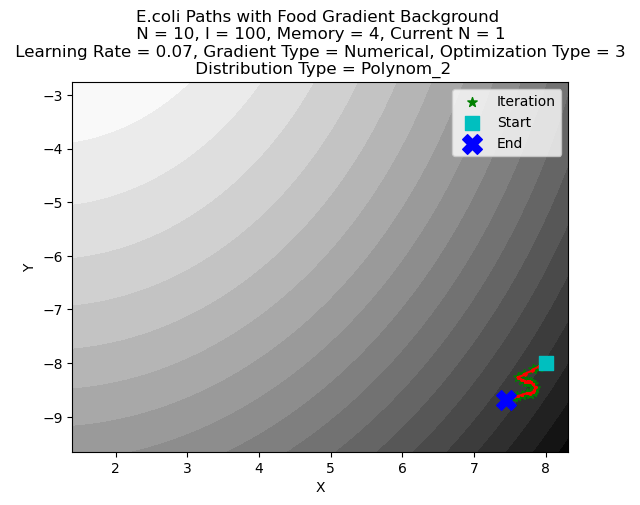

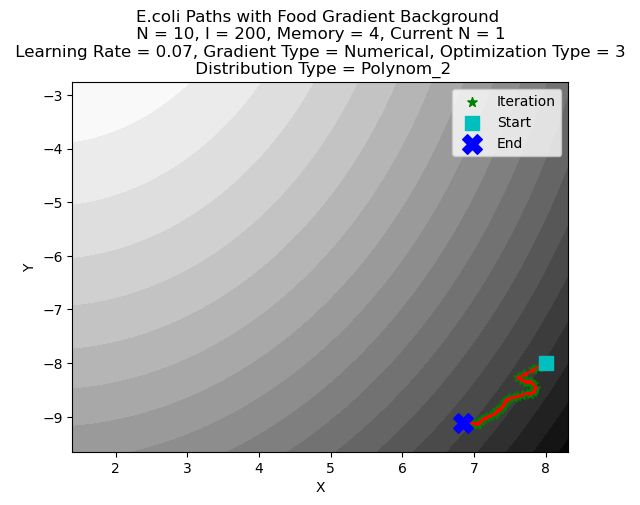

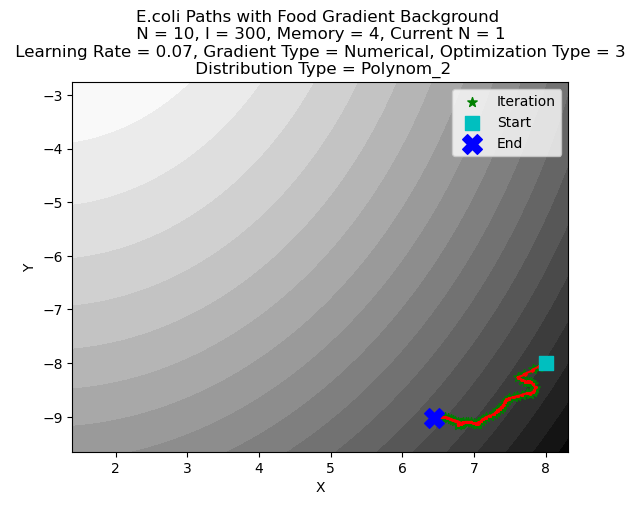

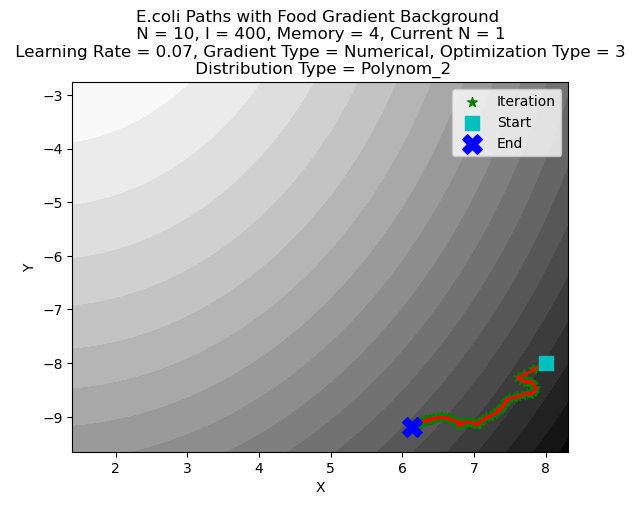

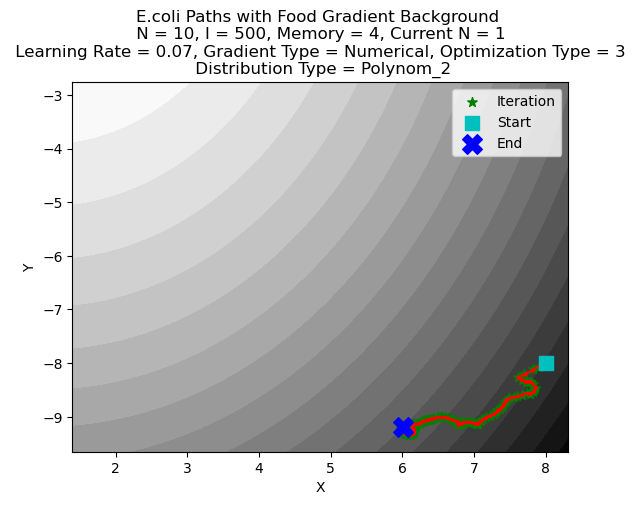

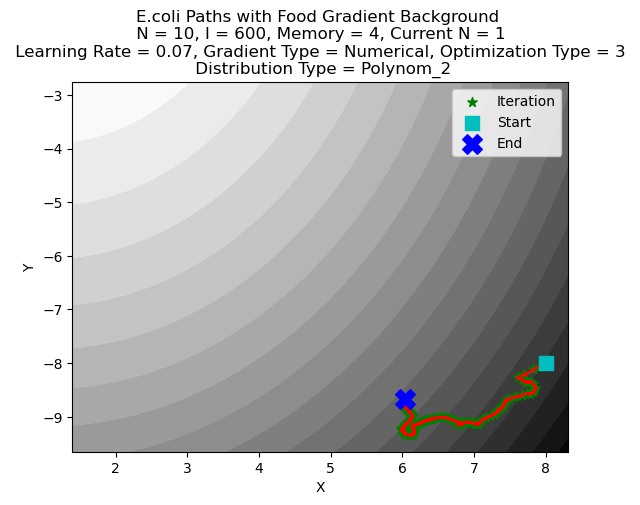

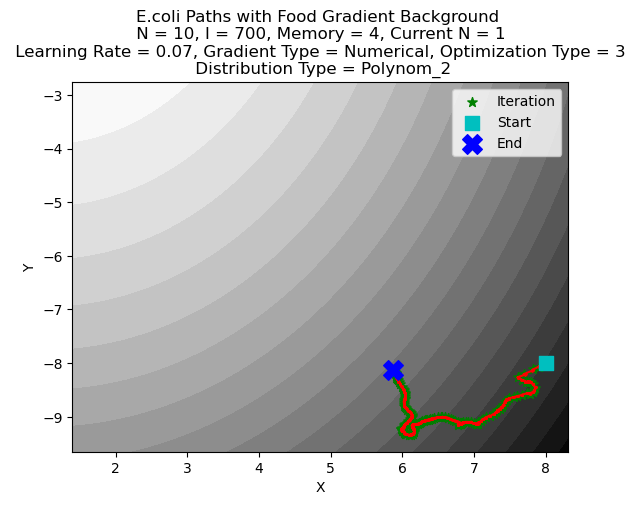

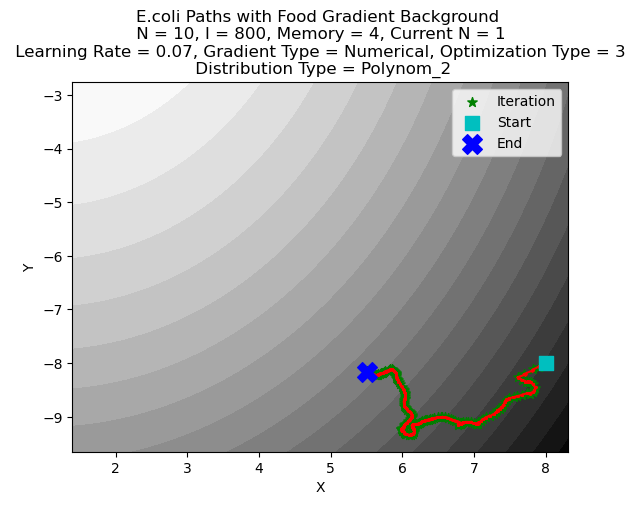

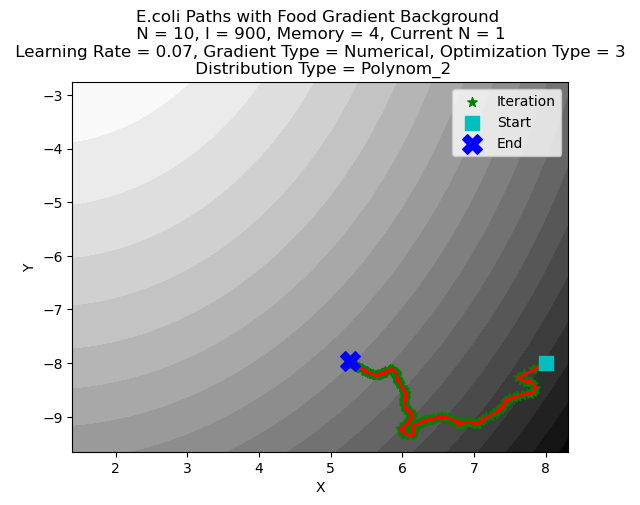

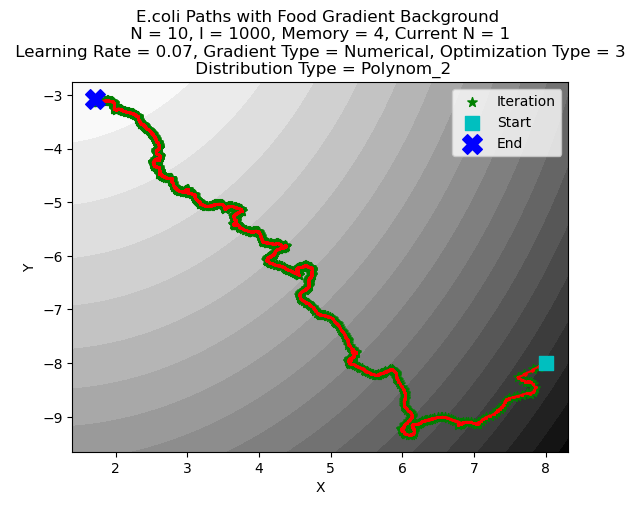

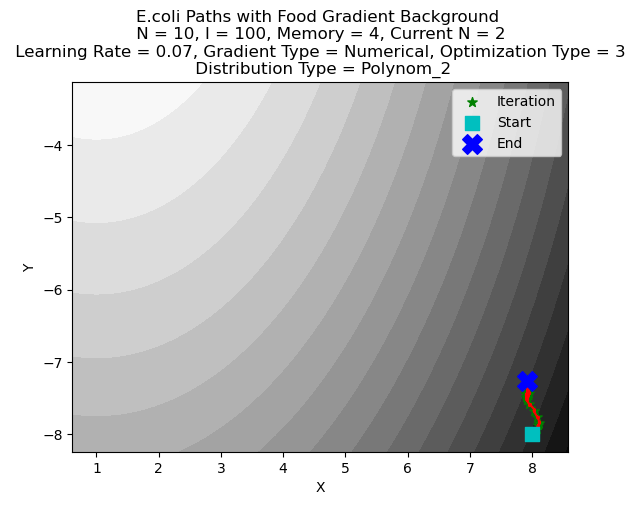

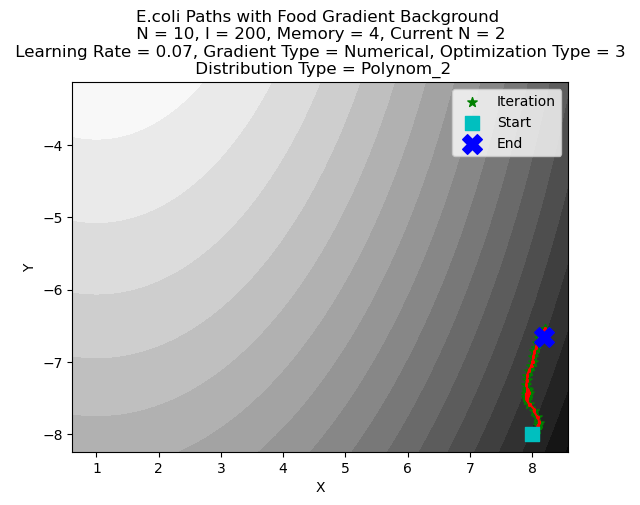

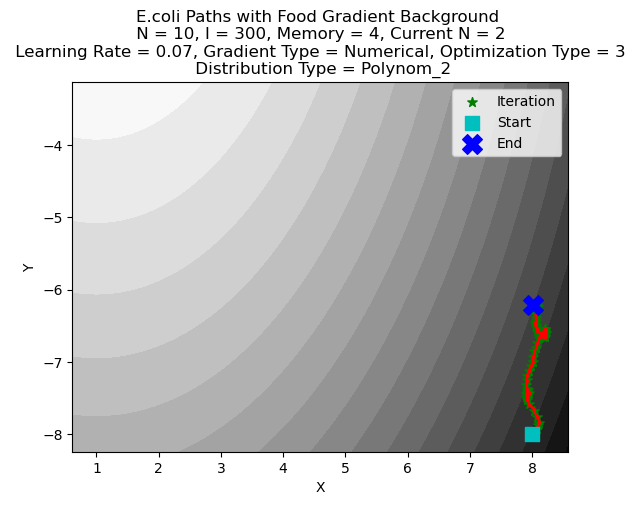

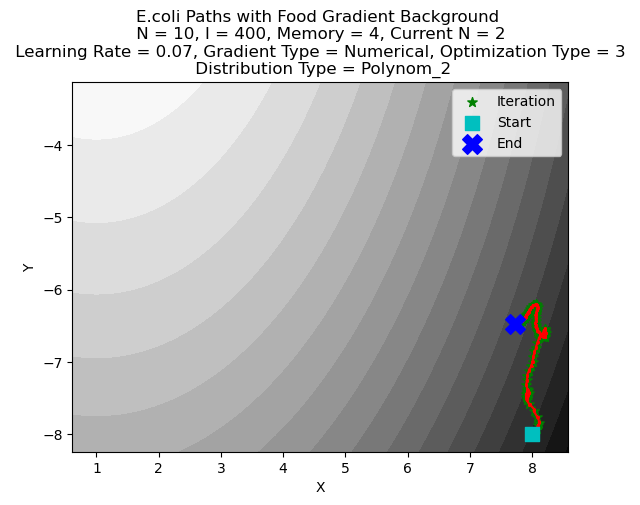

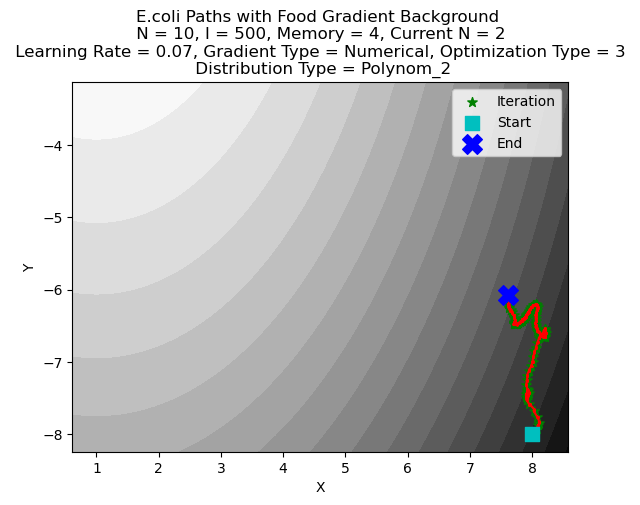

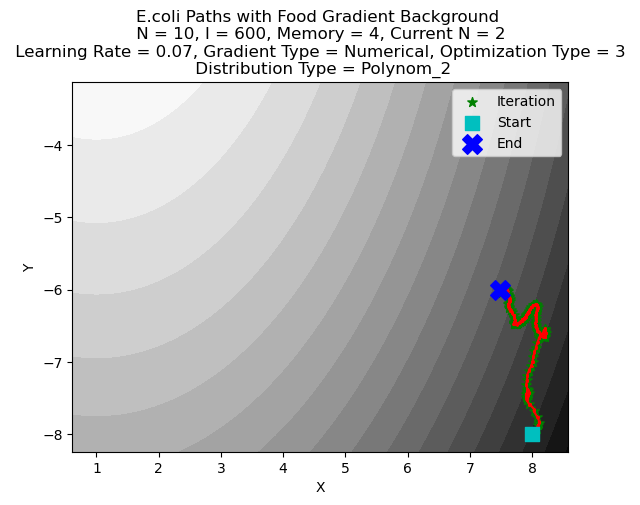

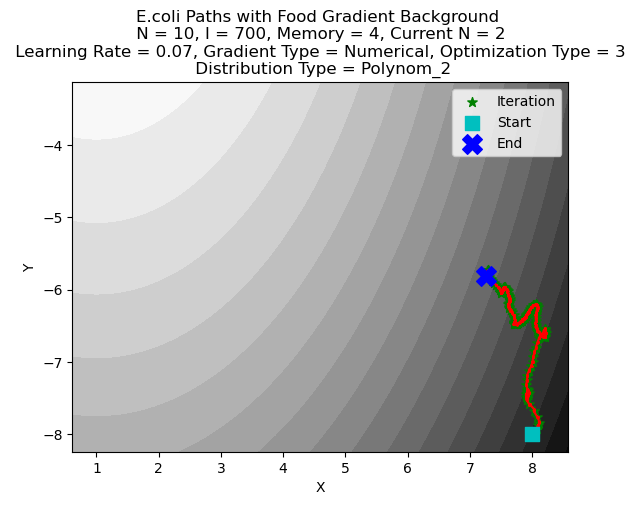

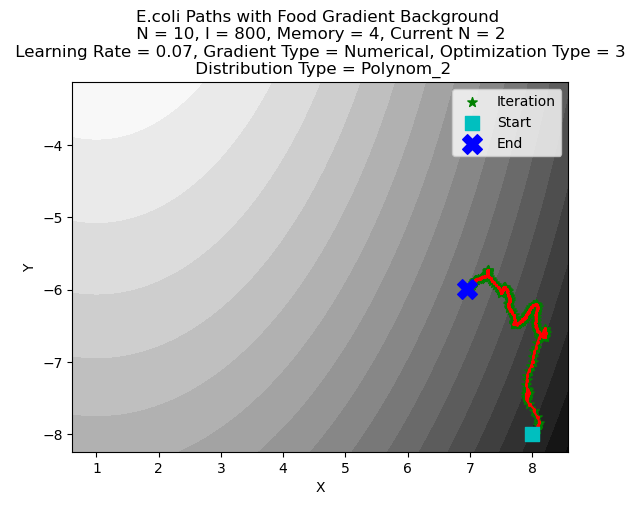

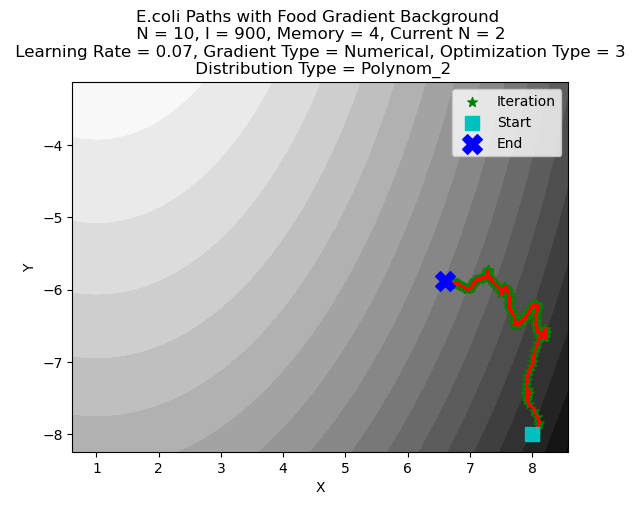

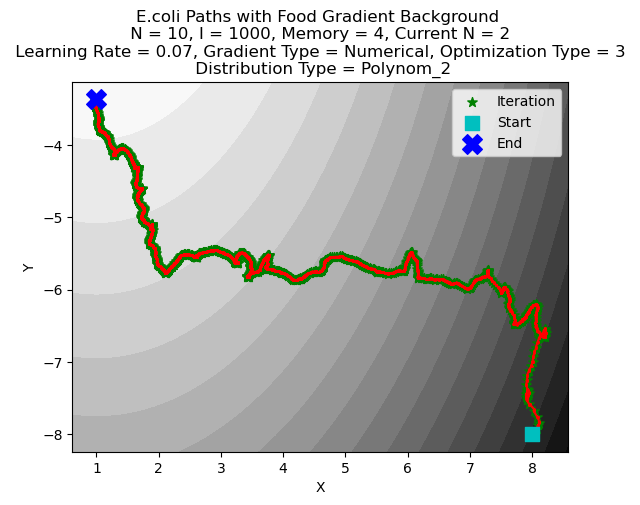

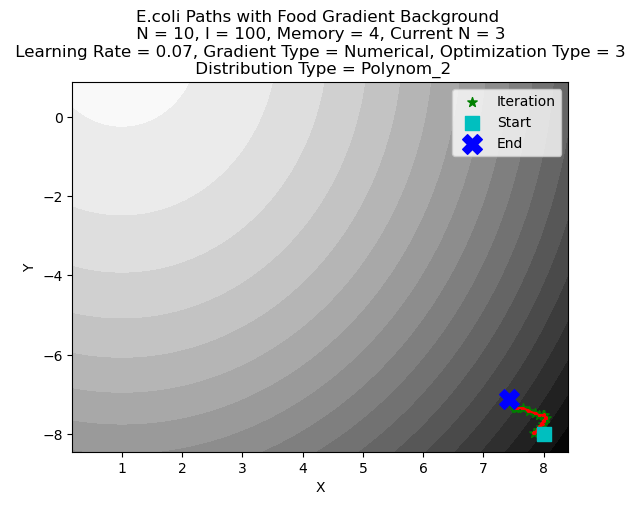

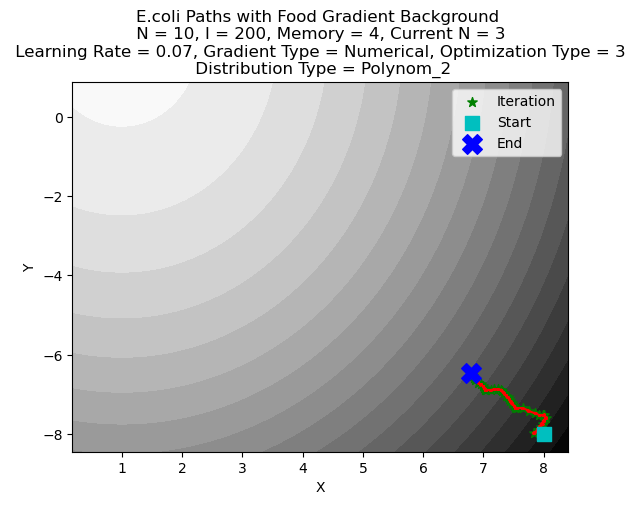

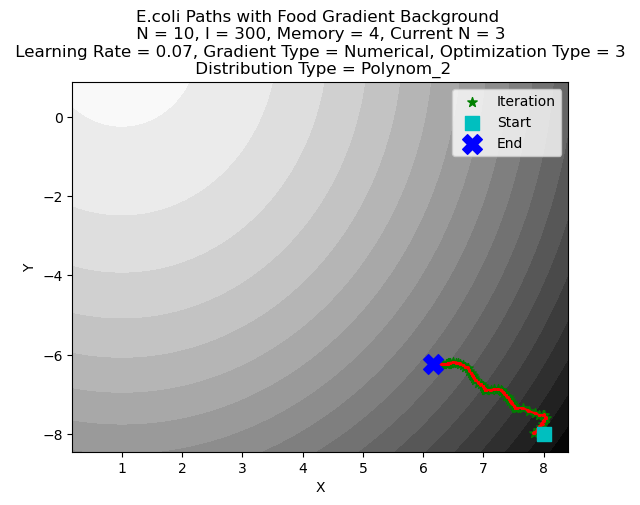

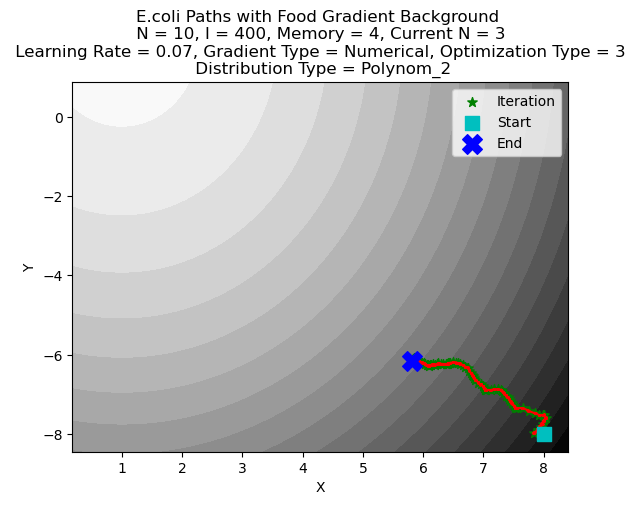

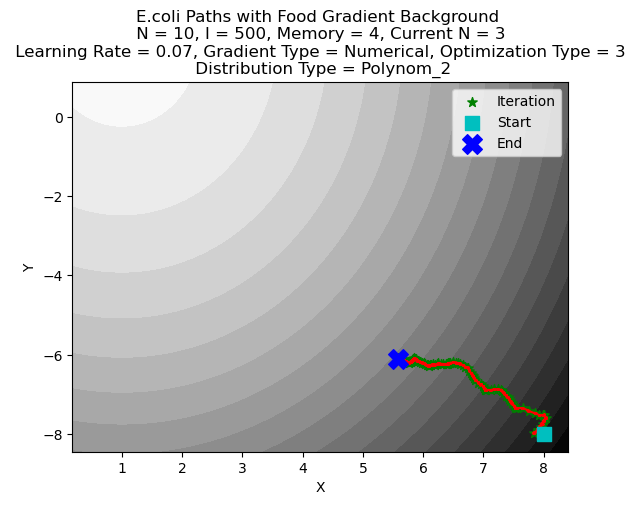

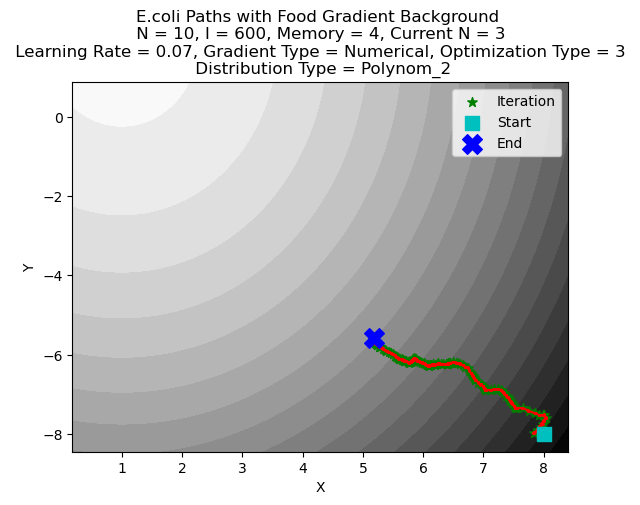

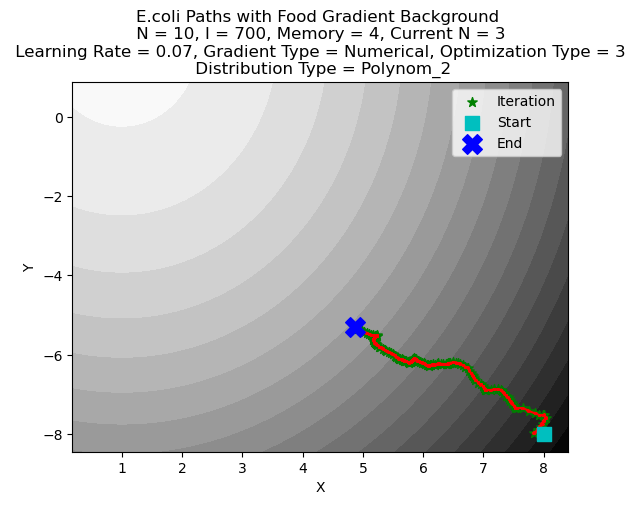

KeyboardInterrupt: 

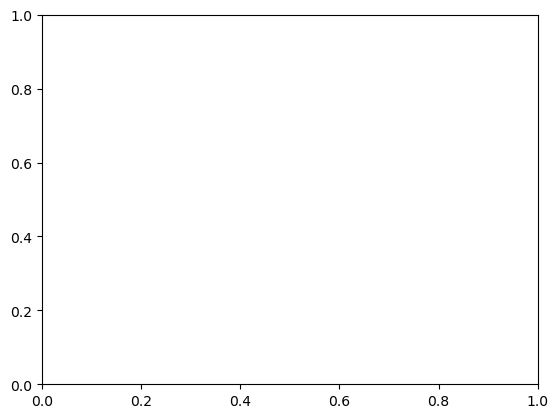

In [2]:
test = Ecoli_Walk(iterationCount = 1000, optimizeType= 3,learningRate = 0.07, analytical_Grad = False, foodFunctionType = 'Polynom_2', N = 10)
test.EcoliWalk_Simulation()

In [ ]:
test2 = Ecoli_Walk(iterationCount = 1000, optimizeType= 3,learningRate = 0.07, analytical_Grad = False, foodFunctionType = 'Polynom_4', N = 100)
test2.EcoliWalk_Simulation()

In [ ]:
test3 = Ecoli_Walk(iterationCount = 500, optimizeType= 3,learningRate = 0.07, analytical_Grad = False, foodFunctionType = 'Normal_Dist', N = 1000)
test3.EcoliWalk_Simulation()

In [ ]:
test4 = Ecoli_Walk(iterationCount = 1000, optimizeType= 5,learningRate = 0.05, analytical_Grad = False, foodFunctionType = 'Polynom_4', N = 10)
test4.EcoliWalk_Simulation()

In [ ]:
test5 = Ecoli_Walk(iterationCount = 1000, optimizeType= 5,learningRate = 0.04, analytical_Grad = False, foodFunctionType = 'Normal_Dist', N = 100)
test5.EcoliWalk_Simulation()

In [ ]:
test6 = Ecoli_Walk(iterationCount = 500, optimizeType= 5,learningRate = 0.04, analytical_Grad = False, foodFunctionType = 'Polynom_2', N = 1000)
test6.EcoliWalk_Simulation()